# Settings

In [1]:
# Load Reticulate function
Sys.setenv(RETICULATE_PYTHON="/home/luca/anaconda3/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/luca/anaconda3/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/luca/anaconda3/envs/reticulate")
reticulate::py_module_available(module='anndata') #needs to be TRUE
reticulate::import('anndata') #good to make sure this doesn't error
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(anndata)

[1] TRUE

Module(leidenalg)

In [2]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, Matrix,forcats,
               hdf5r, Seurat, Signac,harmony, knitr, SoupX, HGNChelper, openxlsx,
               logr, parallel, future,
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x)

In [3]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

# set Future
plan("multicore", workers = 4)
# set RAM treshold
## 1000 = 1gb
RAM.tresh = 10000 * 1024^2
options(future.globals.maxSize = RAM.tresh)

In [4]:
# Set directories
fastq.dir = "/nfs/lab/projects/COVID_mouse/raw_data/230616_A01535_0344_BH7LF2DSX7_2/"
base.dir = "/nfs/lab/projects/COVID_mouse/"
assets.dir = "/nfs/lab/projects/COVID_mouse/assets/"
cell.ranger.dir = paste(base.dir, "cell.ranger/", sep = "")
seurat.dir = paste(base.dir, "seurat/", sep = "")
step1.dir = paste(seurat.dir, "1_pre.processing/", sep = "")
step2.dir = paste(seurat.dir, "2_SoupX/", sep = "")
step3.dir = paste(seurat.dir, "3_scrublet/", sep = "")
step4.dir = paste(seurat.dir, "4_merge.samples/", sep = "")

In [5]:
# Subclustering function
FindSubClusters <- function(object,
                            cluster,
                            graph.name,
                            subcluster.name = "sub.cluster",
                            resolution = 0.5,
                            algorithm = 4) {
  sub.cell <- WhichCells(object = object, idents = cluster)
  sub.graph <- as.Graph(x = object[[graph.name]][sub.cell, sub.cell])
  sub.clusters <- FindClusters(object = sub.graph,
                               resolution = resolution,
                               algorithm = algorithm,
                               method = 'igraph')
  sub.clusters[, 1] <- paste(cluster,  sub.clusters[, 1], sep = "_")
  object[[subcluster.name]] <- as.character(x = Idents(object = object))
  object[[subcluster.name]][sub.cell, ] <- sub.clusters[, 1]
  return(object)
}

In [6]:
# Load markers list
cell.markers = read.table(paste(assets.dir, "Cell.markers_3.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]
compartment.ls = unique(cell.markers$Compartment)
celltype.ls = unique(cell.markers$Celltype)
# Factorize columns
cell.markers$Compartment = factor(cell.markers$Compartment, 
                        levels = compartment.ls)
cell.markers$CellType = factor(cell.markers$Celltype,
                        levels = celltype.ls)

In [7]:
# start log
options("logr.on" = TRUE, "logr.notes" = TRUE)
options("logr.autolog" = TRUE)
options("logr.compact" = TRUE)
options("logr.traceback" = TRUE)
log.file = paste(base.dir, Sys.Date(),".6_SubClustering.log", sep="")

In [8]:
log_open(log.file)

[1] "/nfs/lab/projects/COVID_mouse/log/2023-10-23.6_SubClustering.log"

# Load data

In [9]:
adata = readRDS(paste(step4.dir, "snRNAseq_mrg.rds", sep = ""))

In [10]:
# Remove the samples we don't need
unique(adata$library)
sample.remove = c("7_G1B1", "8_G1B2", "9_G1B3")
sample.keep = unique(adata$library)
sample.keep = sample.keep[!sample.keep %in% sample.remove]
sample.keep

[1] "1_GFP1"  "10_G1C1" "11_G1C2" "12_G1C3" "2_GFP2"  "3_GFP3"  "4_RBD1" 
 [8] "5_RBD2"  "6_RBD3"  "7_G1B1"  "8_G1B2"  "9_G1B3"

[1] "1_GFP1"  "10_G1C1" "11_G1C2" "12_G1C3" "2_GFP2"  "3_GFP3"  "4_RBD1" 
[8] "5_RBD2"  "6_RBD3"

In [11]:
adata = subset(adata, library %in% sample.keep)

In [12]:
# Fix mitogenes (mouse doesn't have the caps)
adata[['percent.mt']] <- PercentageFeatureSet(adata, pattern = "^mt-")

## re-analyze and Adjust resolution

In [13]:
adata.backup = adata

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



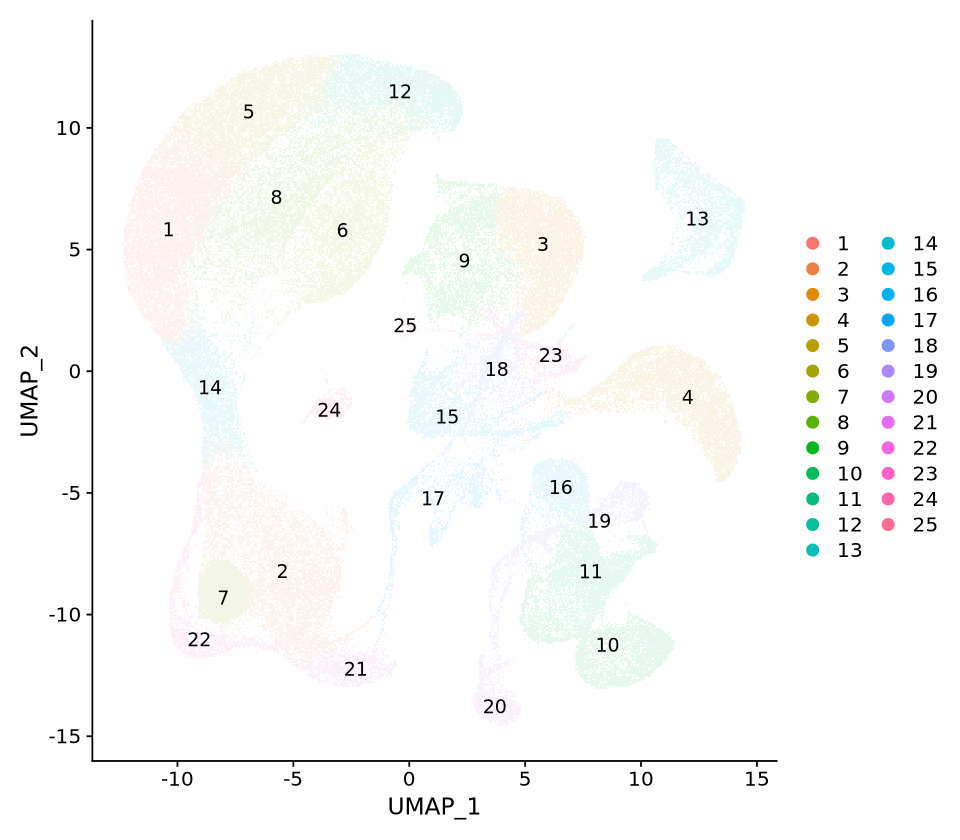

In [14]:
options(repr.plot.height = 7, repr.plot.width = 8)
DimPlot(adata, reduction = "umap", label = TRUE, pt.size = .1)

In [15]:
gc(reset = TRUE)
# RNA analysis
DefaultAssay(adata) <- 'RNA'
adata <- SCTransform(adata, verbose = FALSE) 
gc(reset = TRUE)  

DefaultAssay(adata) <- "SCT"
adata = RunPCA(adata, verbose = FALSE)
adata = RunHarmony(adata, group.by.vars='library', assay.use='SCT', reduction.save='harmony')

used       (Mb)    gc trigger (Mb)    max used   (Mb)   
Ncells   11232197   599.9   17423708   930.6   11232197   599.9
Vcells 2936806595 22406.1 8681914739 66237.8 2936806595 22406.1

used       (Mb)    gc trigger  (Mb)    max used   (Mb)   
Ncells   11318426   604.5    17423708   930.6   11318426   604.5
Vcells 4070358869 31054.4 12002111894 91568.9 4070358869 31054.4

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony converged after 8 iterations



In [16]:
adata = RunUMAP(adata, reduction = "harmony", dims = 1:20)
adata = FindNeighbors(adata, reduction = "harmony", dims = 1:20)
adata = FindClusters(adata, algorithm = 4, resolution = 5, method = "igraph")

16:39:27 UMAP embedding parameters a = 0.9922 b = 1.112

16:39:27 Read 133649 rows and found 20 numeric columns

16:39:27 Using Annoy for neighbor search, n_neighbors = 30

16:39:27 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:39:44 Writing NN index file to temp file /nfs/lab/Luca/TMP/RtmpfbmcBg/file3435d151872d6d

16:39:45 Searching Annoy index using 4 threads, search_k = 3000

16:40:07 Annoy recall = 100%

16:40:08 Commencing smooth kNN distance calibration using 4 threads
 with target n_neighbors = 30

16:40:15 Initializing from normalized Laplacian + noise (using irlba)

16:41:51 Commencing optimization for 200 epochs, with 5476108 positive edges

16:43:08 Optimization finished

Computing nearest neighbor graph

Computing SNN



Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



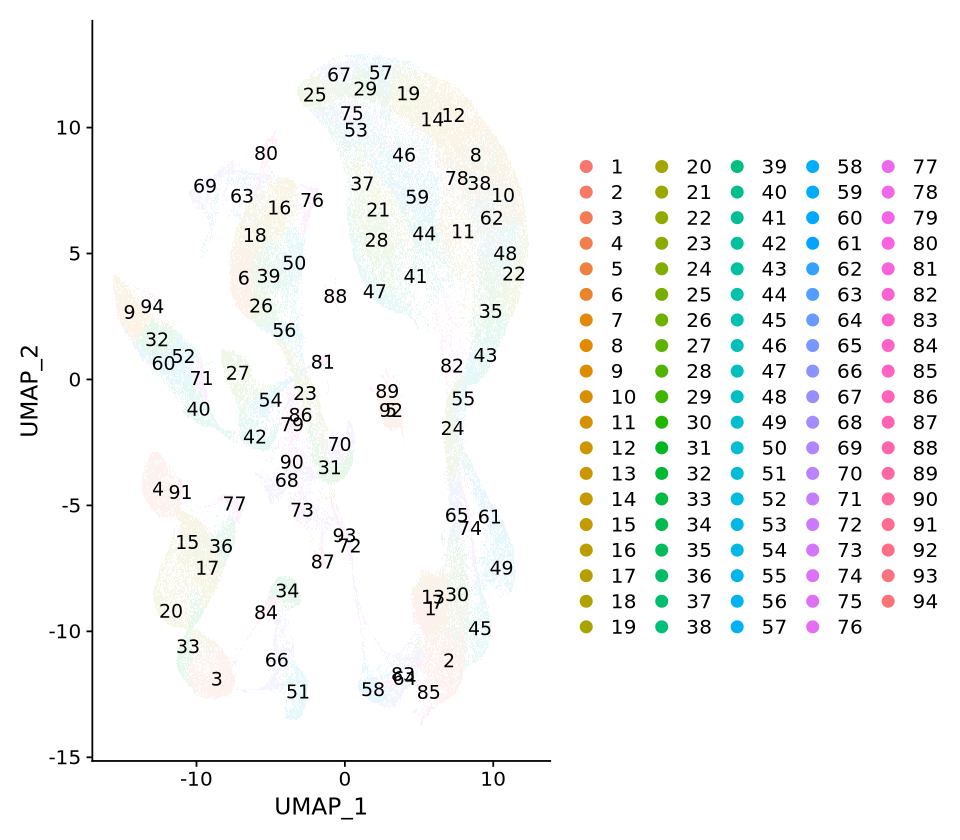

In [17]:
options(repr.plot.height = 7, repr.plot.width = 8)
DimPlot(adata, reduction = "umap", label = TRUE, pt.size = .1)

# Sample QC

In [20]:
sample.ls = levels(factor(adata$library))
sample.ls

[1] "1_GFP1"  "10_G1C1" "11_G1C2" "12_G1C3" "2_GFP2"  "3_GFP3"  "4_RBD1" 
[8] "5_RBD2"  "6_RBD3"

## Figure out thresholds

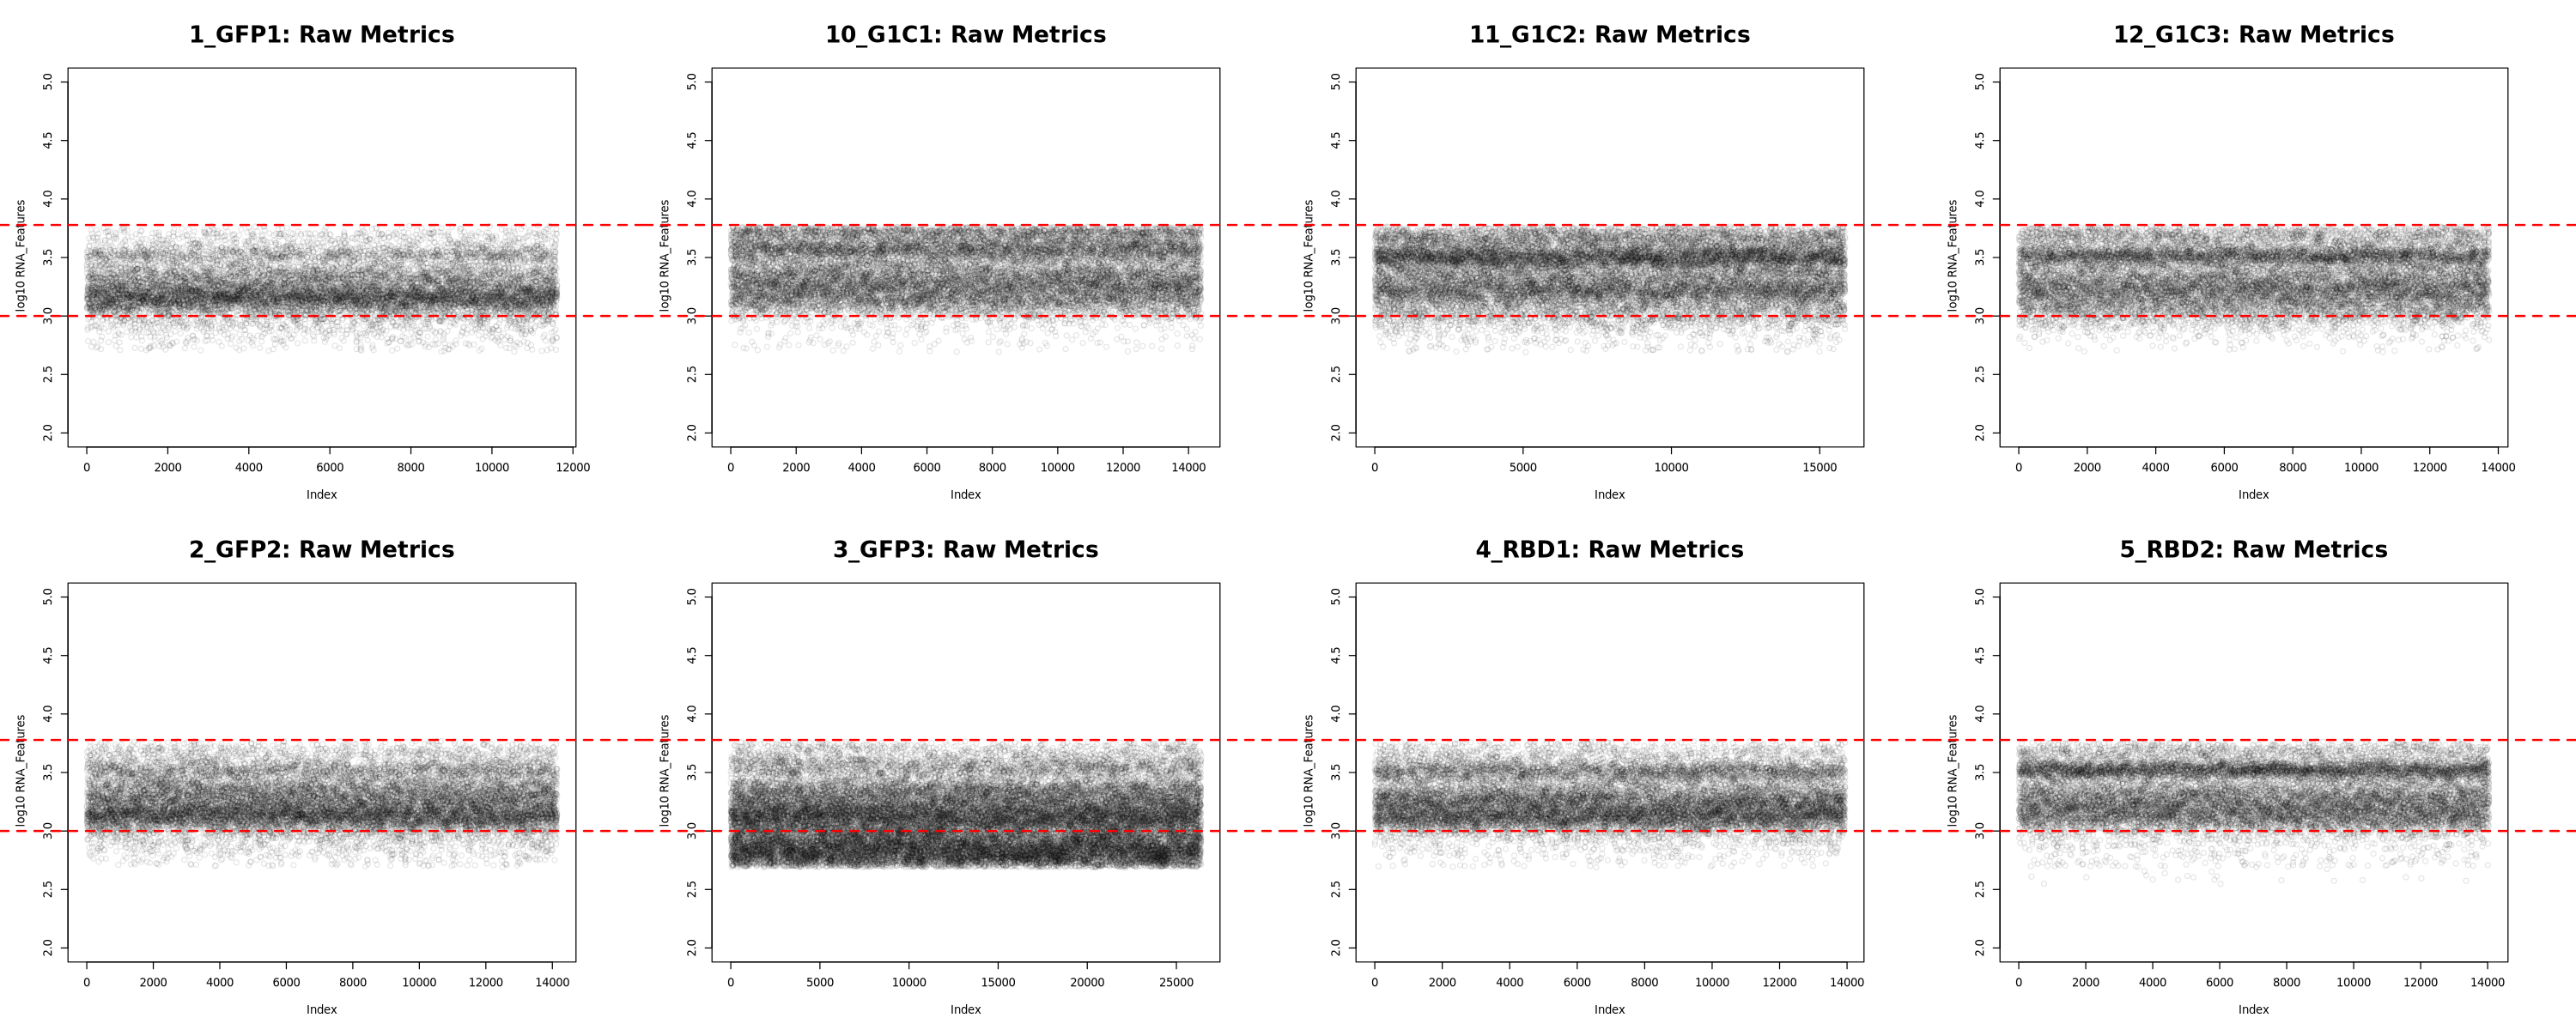

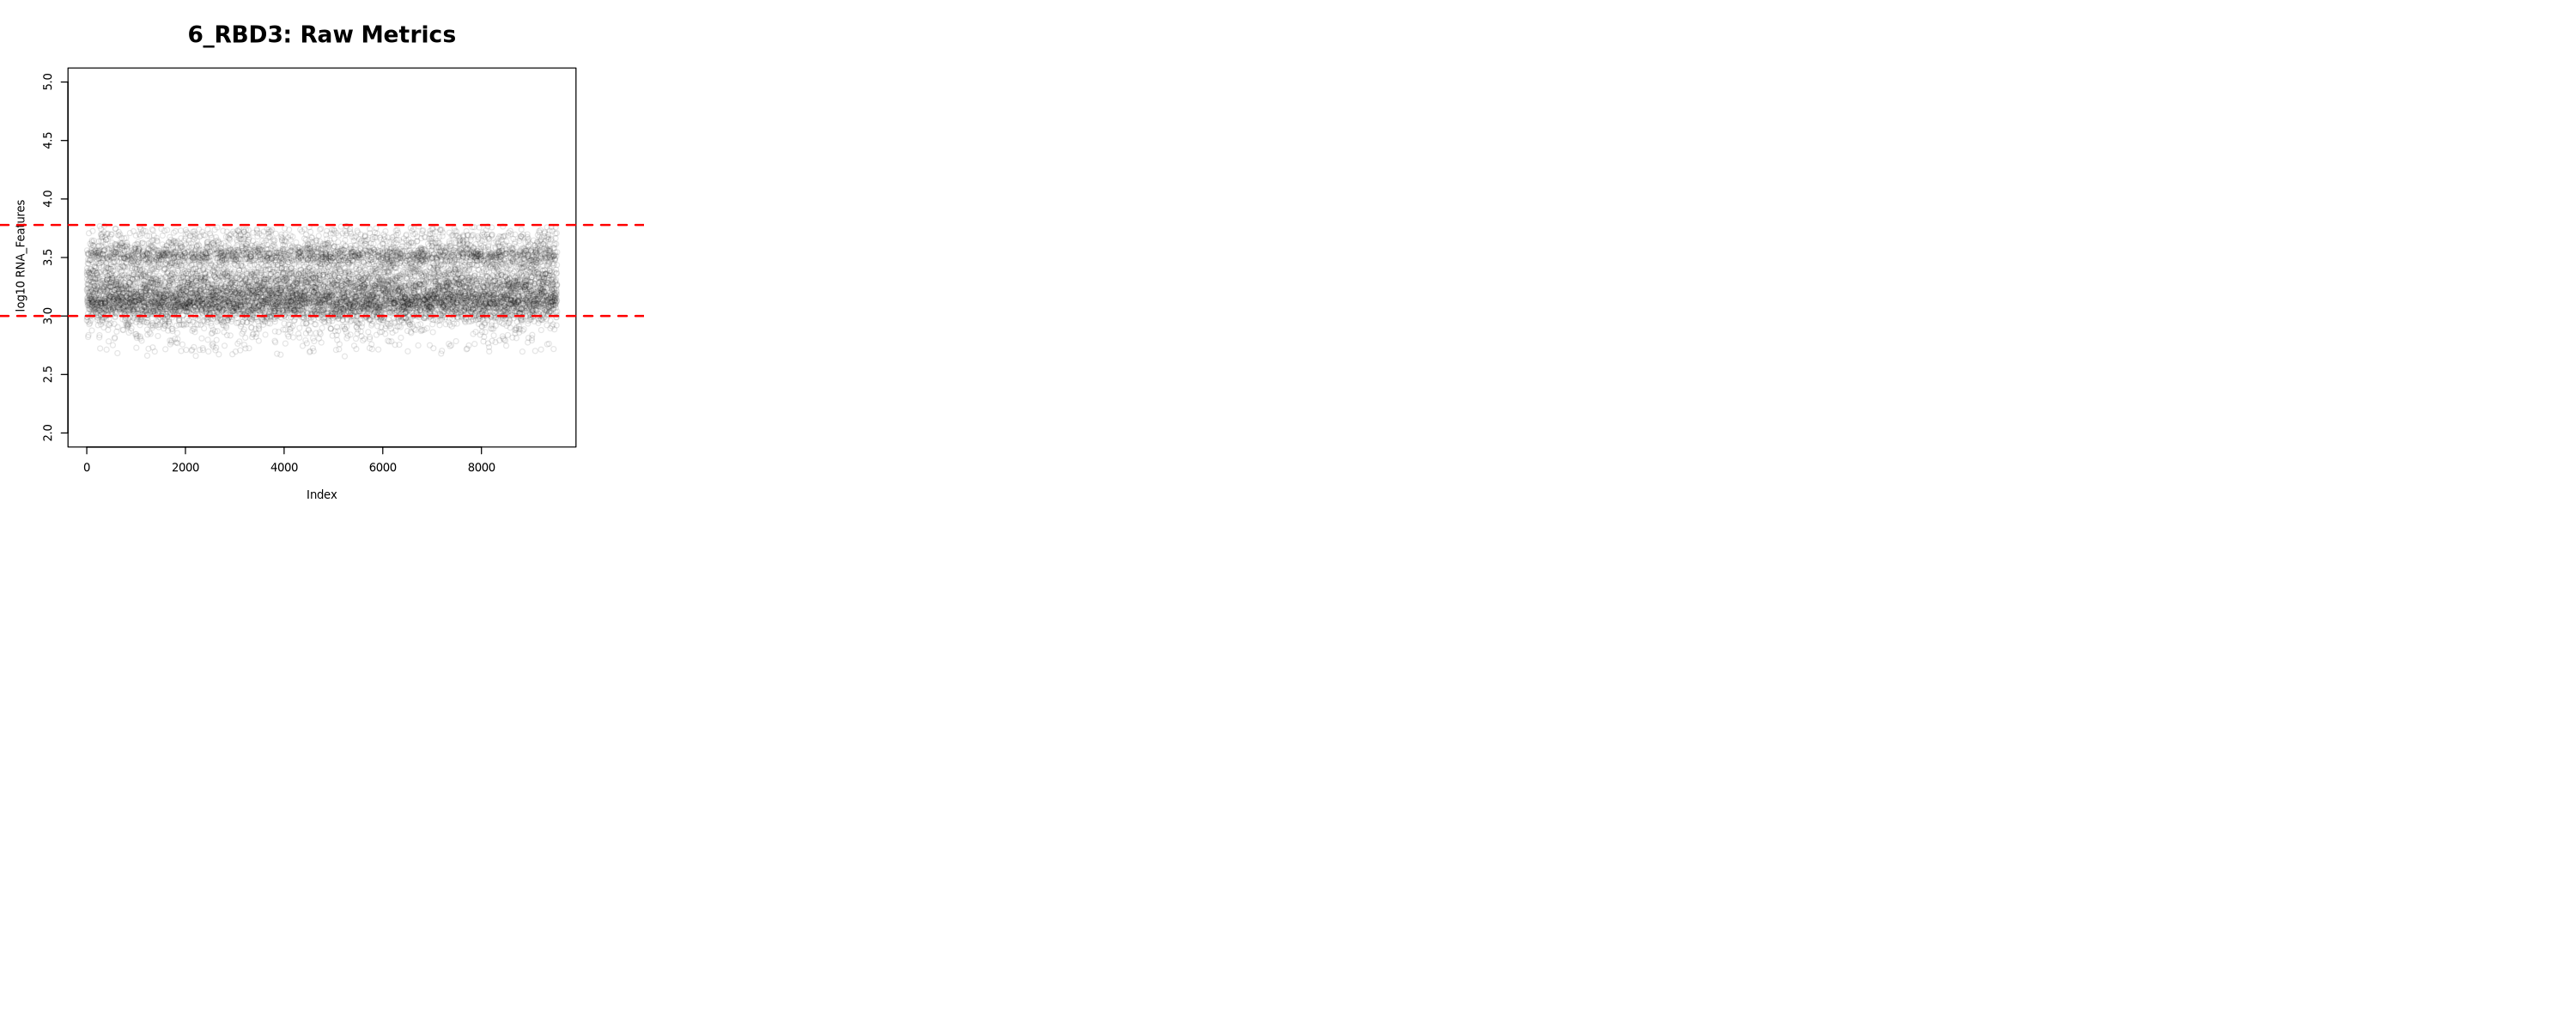

In [21]:
par(mfrow=c(2,4),xpd = T, mar = c(5,5,5,5))
options(repr.plot.width=25, repr.plot.height=10)

for (i in seq_along(sample.ls)){
    sample = sample.ls[i]
    adata.use = subset(x = adata, subset = library == sample)
    plot = plot(log10(adata.use$nFeature_RNA),
     pch=21, col = rgb(0, 0, 0, 0.1),
     ylim = c(2, 5),
     ylab= "\n log10 RNA_Features",
         cex=1, cex.main=2, cex.lab=1, cex.axis=1,
         main=sprintf("%s: Raw Metrics",sample))
     # abline(h = log10(750), col="red", lwd=2, lty=2)
     abline(h = log10(1000), col="red", lwd=2, lty=2)
     abline(h = log10(6000), col="red", lwd=2, lty=2)
}

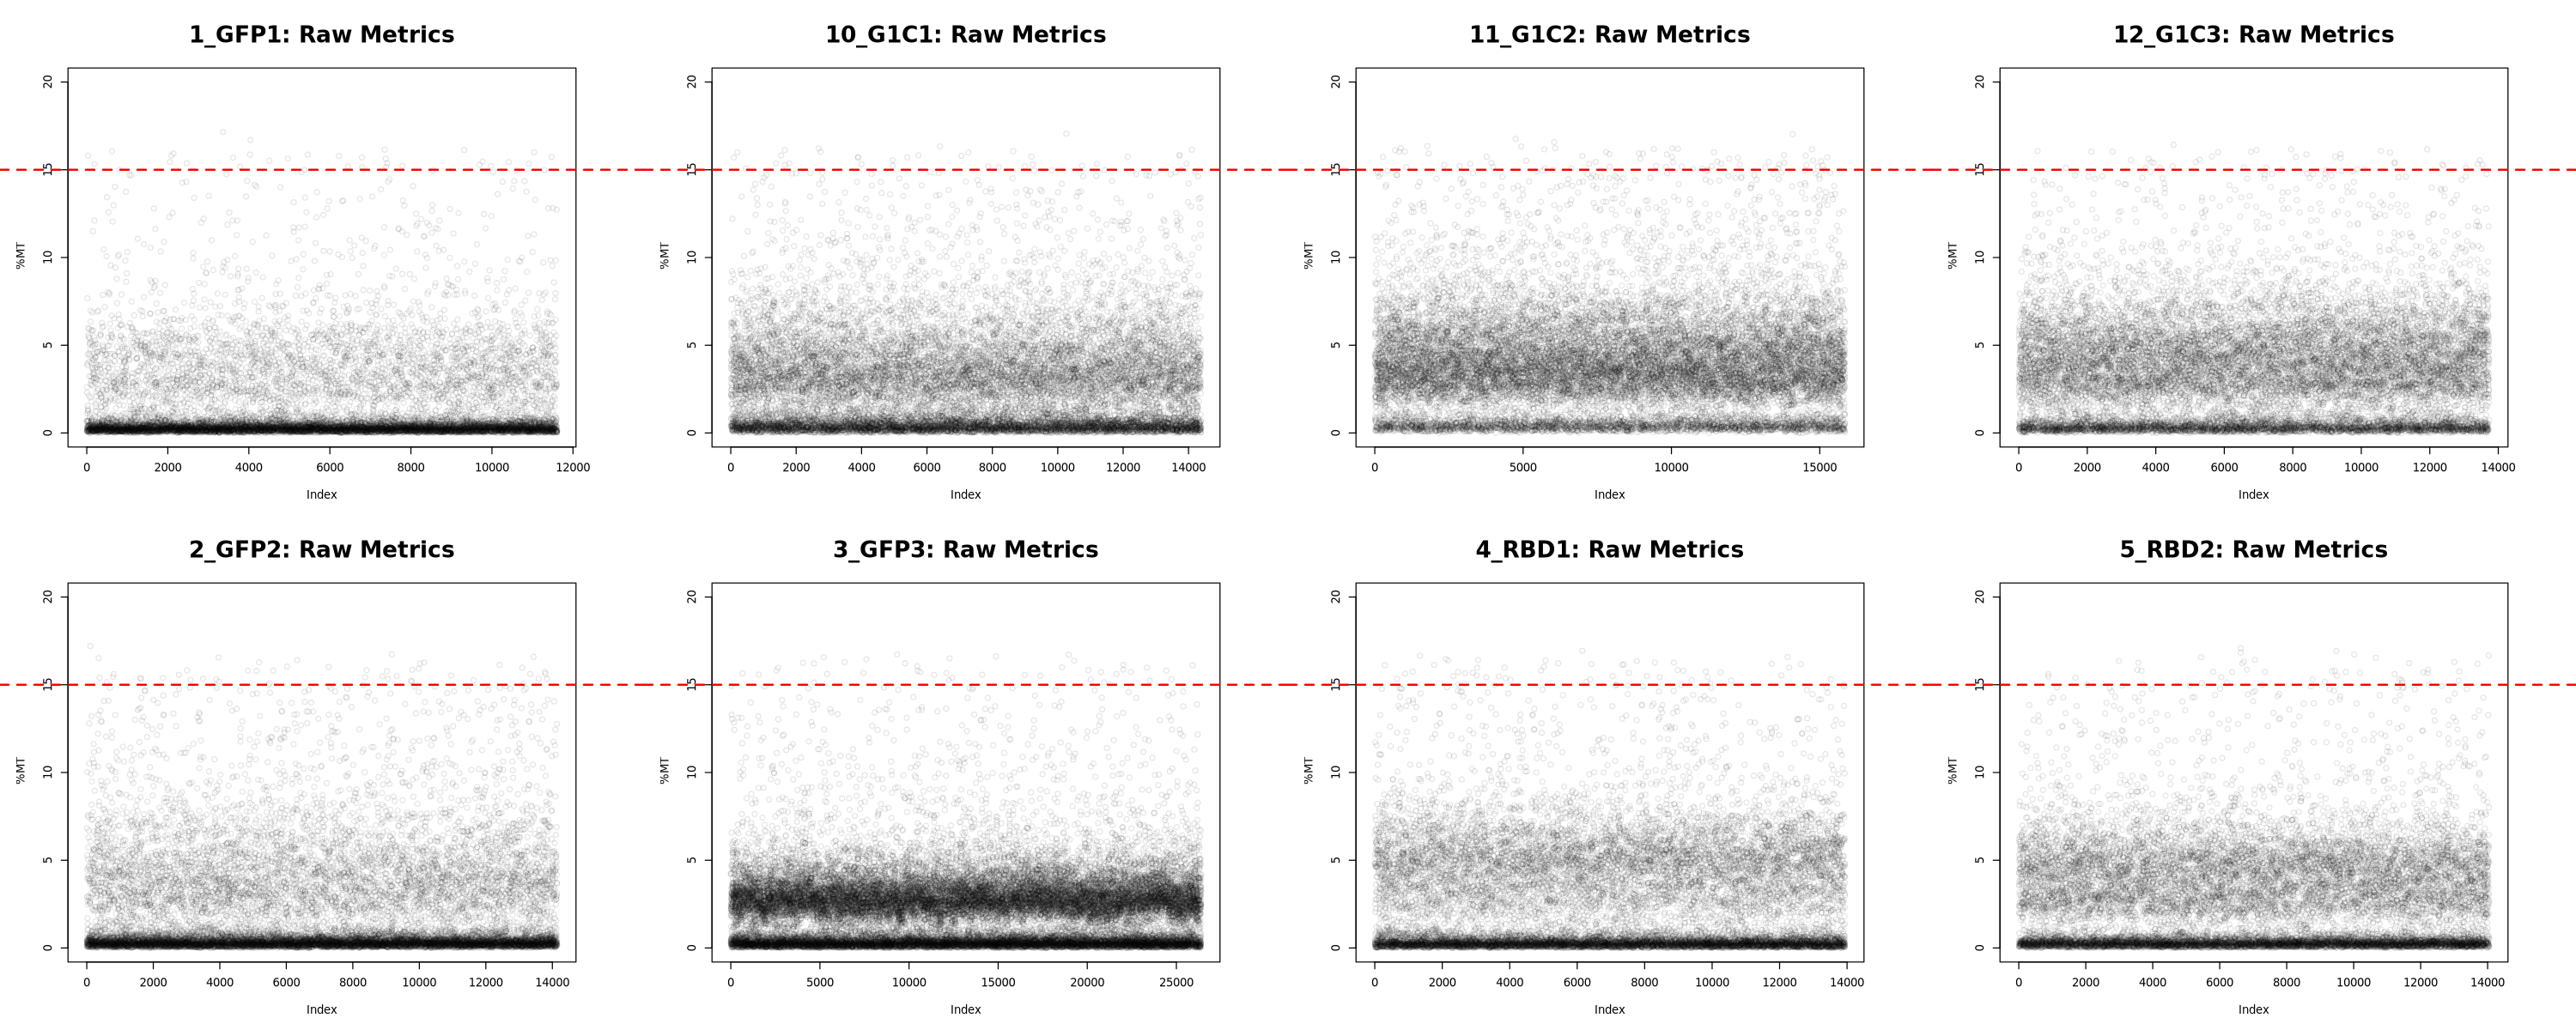

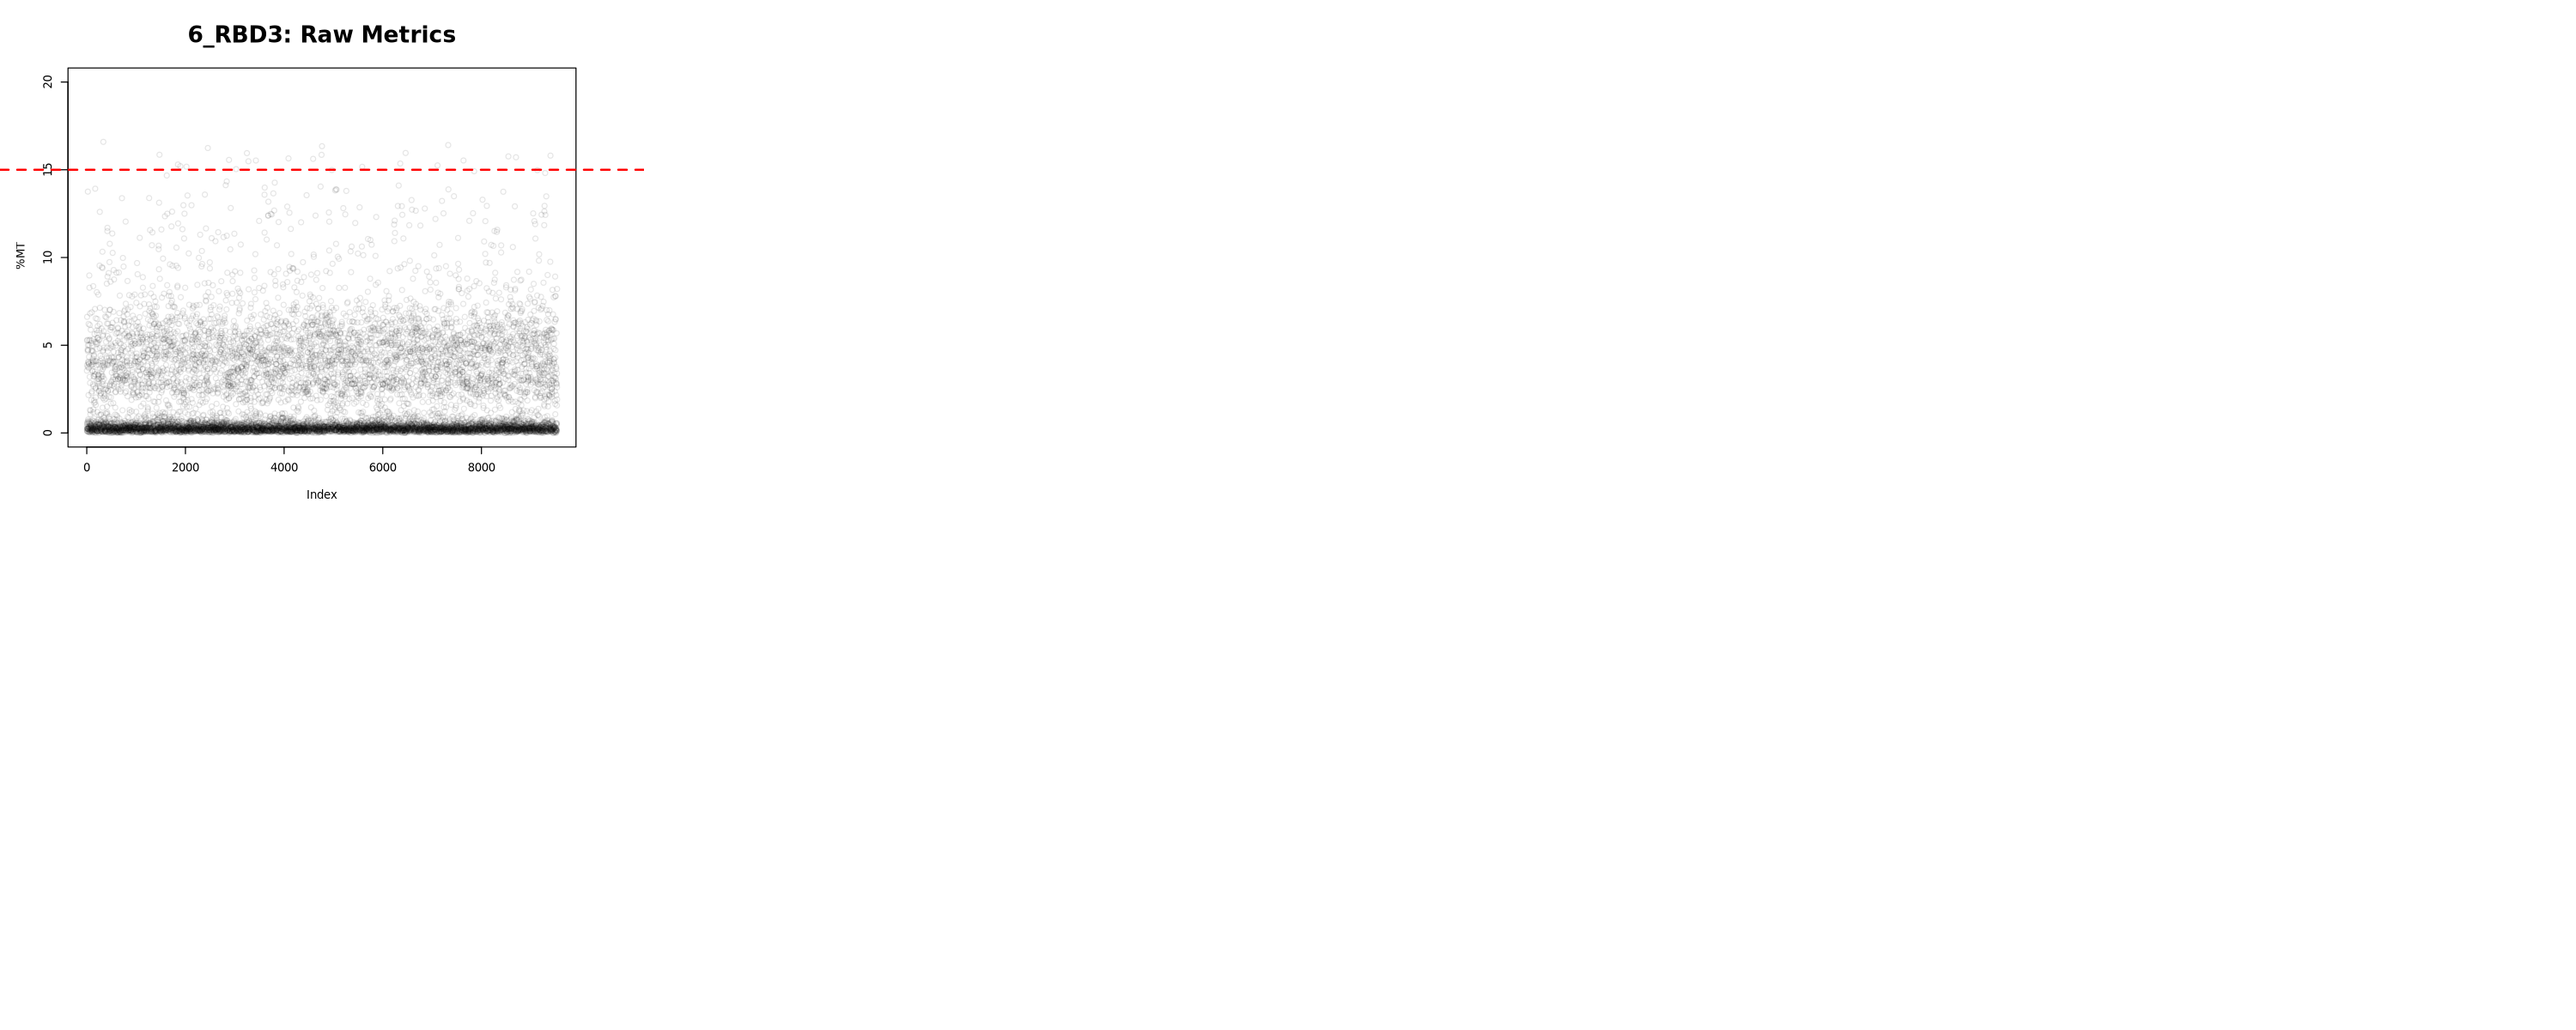

In [22]:
par(mfrow=c(2,4),xpd = T, mar = c(5,5,5,5))
options(repr.plot.width=25, repr.plot.height=10)

for (i in seq_along(sample.ls)){
    sample = sample.ls[i]
    adata.use = subset(x = adata, subset = library == sample)
    plot = plot(adata.use@meta.data$percent.mt,
     pch=21, col = rgb(0, 0, 0, 0.1),
     ylim = c(0, 20),
     ylab= "\n %MT",
         cex=1, cex.main=2, cex.lab=1, cex.axis=1,
         main=sprintf("%s: Raw Metrics",sample))
     abline(h = 15, col="red", lwd=2, lty=2)  
}

## Apply filters

In [23]:
#adata.backup = adata
#adata = adata.backup

In [24]:
RNA.tresh.min = 1000

In [25]:
gc(reset = TRUE)
all.barcodes = length(colnames(adata[["RNA"]]))
# Filter by parameter: nFeature_RNA
adata_sub <- subset(x = adata, subset = nFeature_RNA >= RNA.tresh.min)
    Features.min.barcodes = length(colnames(adata_sub[["RNA"]]))

used       (Mb)    gc trigger  (Mb)    max used   (Mb)   
Ncells   11375786   607.6    17423708   930.6   11375786   607.6
Vcells 4304484603 32840.7 12002111894 91568.9 4304484603 32840.7

In [26]:
adata
adata_sub

An object of class Seurat 
86106 features across 133649 samples within 3 assays 
Active assay: SCT (21536 features, 3000 variable features)
 2 other assays present: RNA, RNA_raw
 3 dimensional reductions calculated: pca, harmony, umap

An object of class Seurat 
86106 features across 116182 samples within 3 assays 
Active assay: SCT (21536 features, 3000 variable features)
 2 other assays present: RNA, RNA_raw
 3 dimensional reductions calculated: pca, harmony, umap

In [27]:
cell.sample = as.data.frame(table(adata$library))
colnames(cell.sample)[1] = "sample.ID"

width = 0.8
position = position_dodge(width = width)
gg1 = ggplot(cell.sample, aes(x= sample.ID, y = Freq, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Final Cells: ", length(colnames(adata[["RNA"]])))) +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            ylim(0, 30000)+
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            geom_text(hjust = -0.3, size = 2.9, position = position_dodge(width = width))+
            coord_flip()

cell.sample = as.data.frame(table(adata_sub$library))
colnames(cell.sample)[1] = "sample.ID"

width = 0.8
position = position_dodge(width = width)
gg2 = ggplot(cell.sample, aes(x= sample.ID, y = Freq, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Final Cells: ", length(colnames(adata_sub[["RNA"]])))) +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            ylim(0, 30000)+
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            geom_text(hjust = -0.3, size = 2.9, position = position_dodge(width = width))+
            coord_flip()

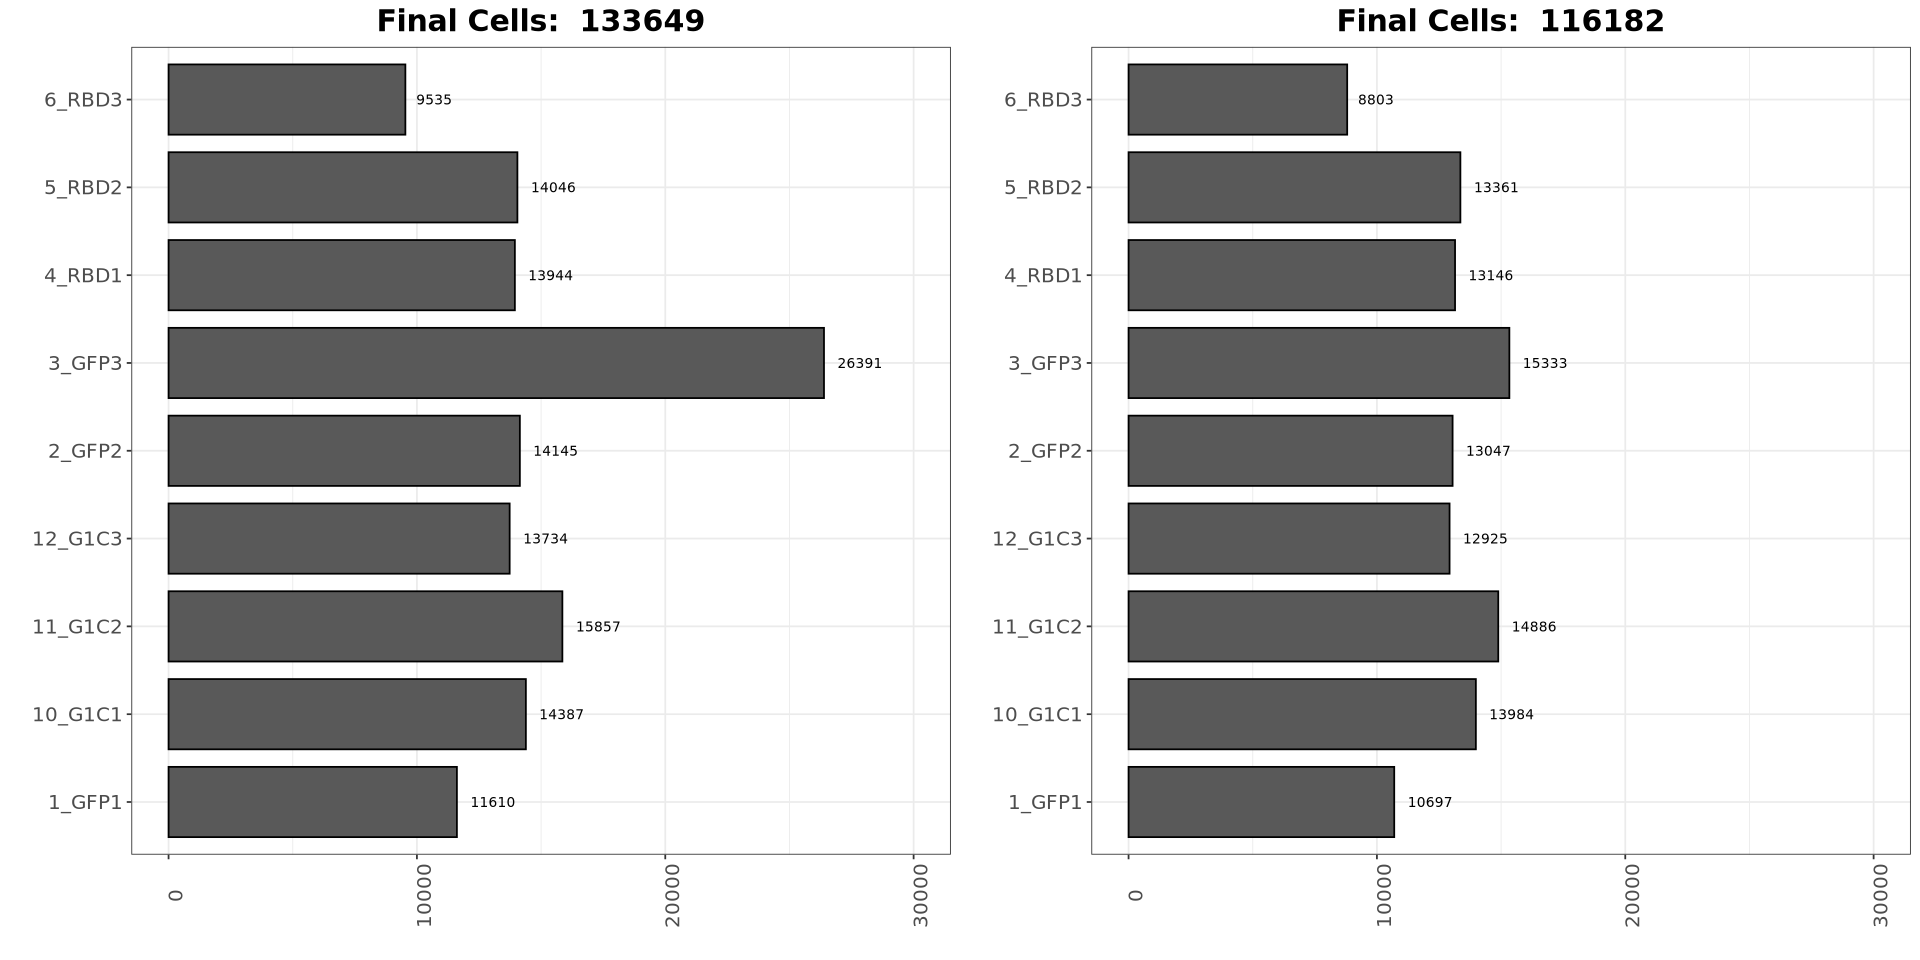

In [28]:
options(repr.plot.height = 8, repr.plot.width = 16)
ggarrange(gg1, gg2, ncol = 2, nrow = 1)

In [29]:
adata = adata_sub

## Analysis and Harmonization

In [30]:
gc(reset = TRUE)
# RNA analysis
DefaultAssay(adata) <- 'RNA'
adata <- SCTransform(adata, verbose = FALSE) 
gc(reset = TRUE)  

DefaultAssay(adata) <- "SCT"
adata = RunPCA(adata, verbose = FALSE)
adata = RunHarmony(adata, group.by.vars='library', assay.use='SCT', reduction.save='harmony')

used       (Mb)    gc trigger  (Mb)    max used   (Mb)   
Ncells   11404842   609.1    17423708   930.6   11404842   609.1
Vcells 5854581398 44667.0 12002111894 91568.9 5854581398 44667.0

used       (Mb)    gc trigger  (Mb)     max used   (Mb)   
Ncells   11405056   609.1    17423708    930.6   11405056   609.1
Vcells 6923367115 52821.1 20739940551 158233.2 6923367115 52821.1

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony converged after 9 iterations



In [31]:
adata = RunUMAP(adata, reduction = "harmony", dims = 1:20)
adata = FindNeighbors(adata, reduction = "harmony", dims = 1:20)
adata = FindClusters(adata, algorithm = 4, resolution = 5, method = "igraph")
gc(reset = TRUE)

17:17:35 UMAP embedding parameters a = 0.9922 b = 1.112

17:17:35 Read 116182 rows and found 20 numeric columns

17:17:35 Using Annoy for neighbor search, n_neighbors = 30

17:17:35 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:17:48 Writing NN index file to temp file /nfs/lab/Luca/TMP/RtmpfbmcBg/file3435d1717dde64

17:17:49 Searching Annoy index using 4 threads, search_k = 3000

17:18:05 Annoy recall = 100%

17:18:07 Commencing smooth kNN distance calibration using 4 threads
 with target n_neighbors = 30

17:18:12 Initializing from normalized Laplacian + noise (using irlba)

17:20:07 Commencing optimization for 200 epochs, with 4685398 positive edges

17:21:13 Optimization finished

Computing nearest neighbor graph

Computing SNN



used       (Mb)    gc trigger  (Mb)     max used   (Mb)   
Ncells   11405949   609.2    17423708    930.6   11405949   609.2
Vcells 6951273578 53034.1 20739940551 158233.2 6951273578 53034.1

In [ ]:
# Remove G1B
# Cluster resultion 5
# Install sctype
# Meet with group next week for sctype

# Cluster QC

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



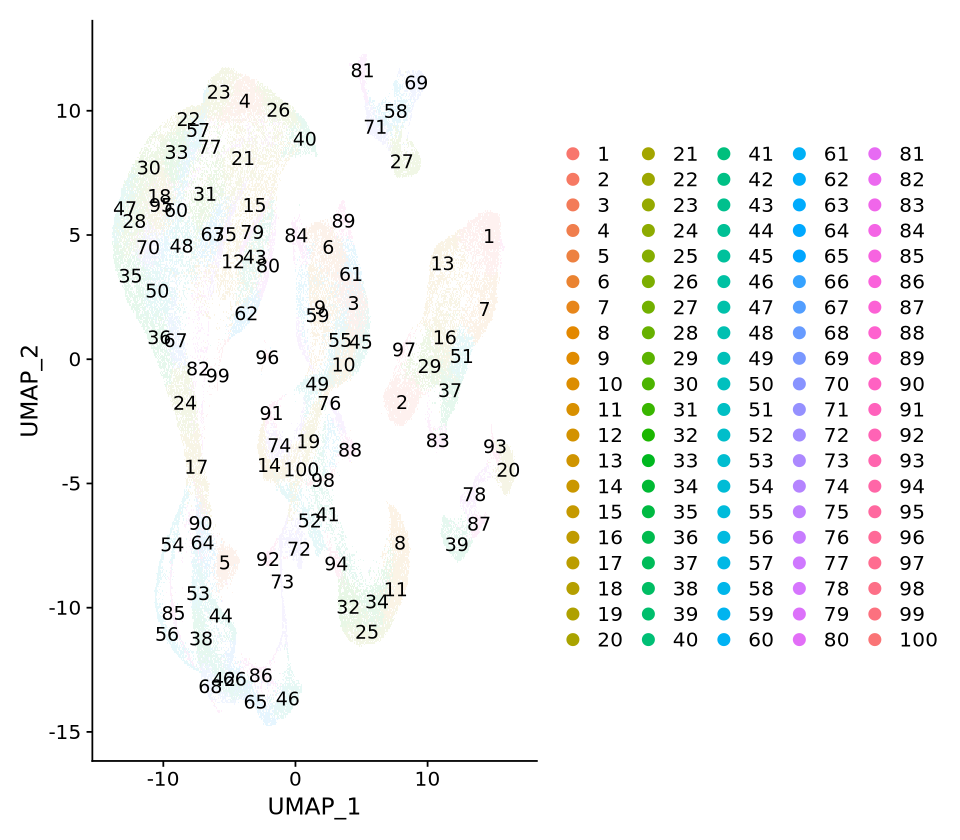

In [32]:
options(repr.plot.height = 7, repr.plot.width = 8)
DimPlot(adata, reduction = "umap", label = TRUE, pt.size = .1)

In [33]:
# add subcluster metadata (to be modified as we go)
adata@meta.data$sub.cluster <- adata@meta.data$seurat_clusters

In [34]:
cell.sample = as.data.frame(table(adata$library))
colnames(cell.sample)[1] = "sample.ID"

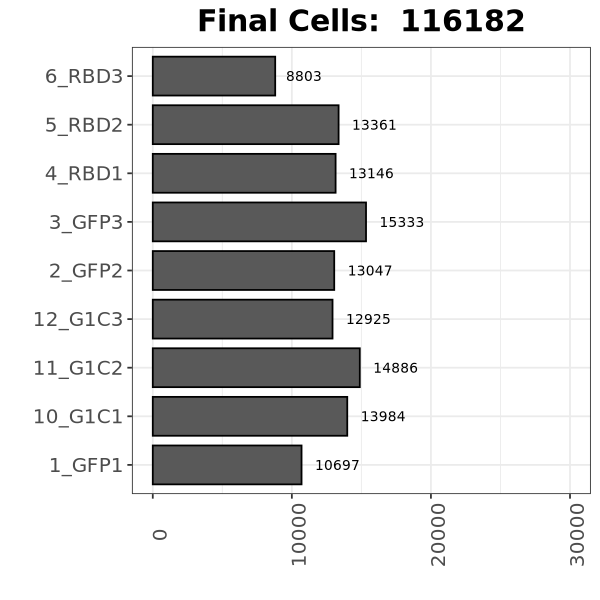

In [35]:
options(repr.plot.width=5, repr.plot.height=5)

width = 0.8
position = position_dodge(width = width)
gg1 = ggplot(cell.sample, aes(x= sample.ID, y = Freq, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Final Cells: ", length(colnames(adata[["RNA"]])))) +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            ylim(0, 30000)+
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            geom_text(hjust = -0.3, size = 2.9, position = position_dodge(width = width))+
            coord_flip()
gg1

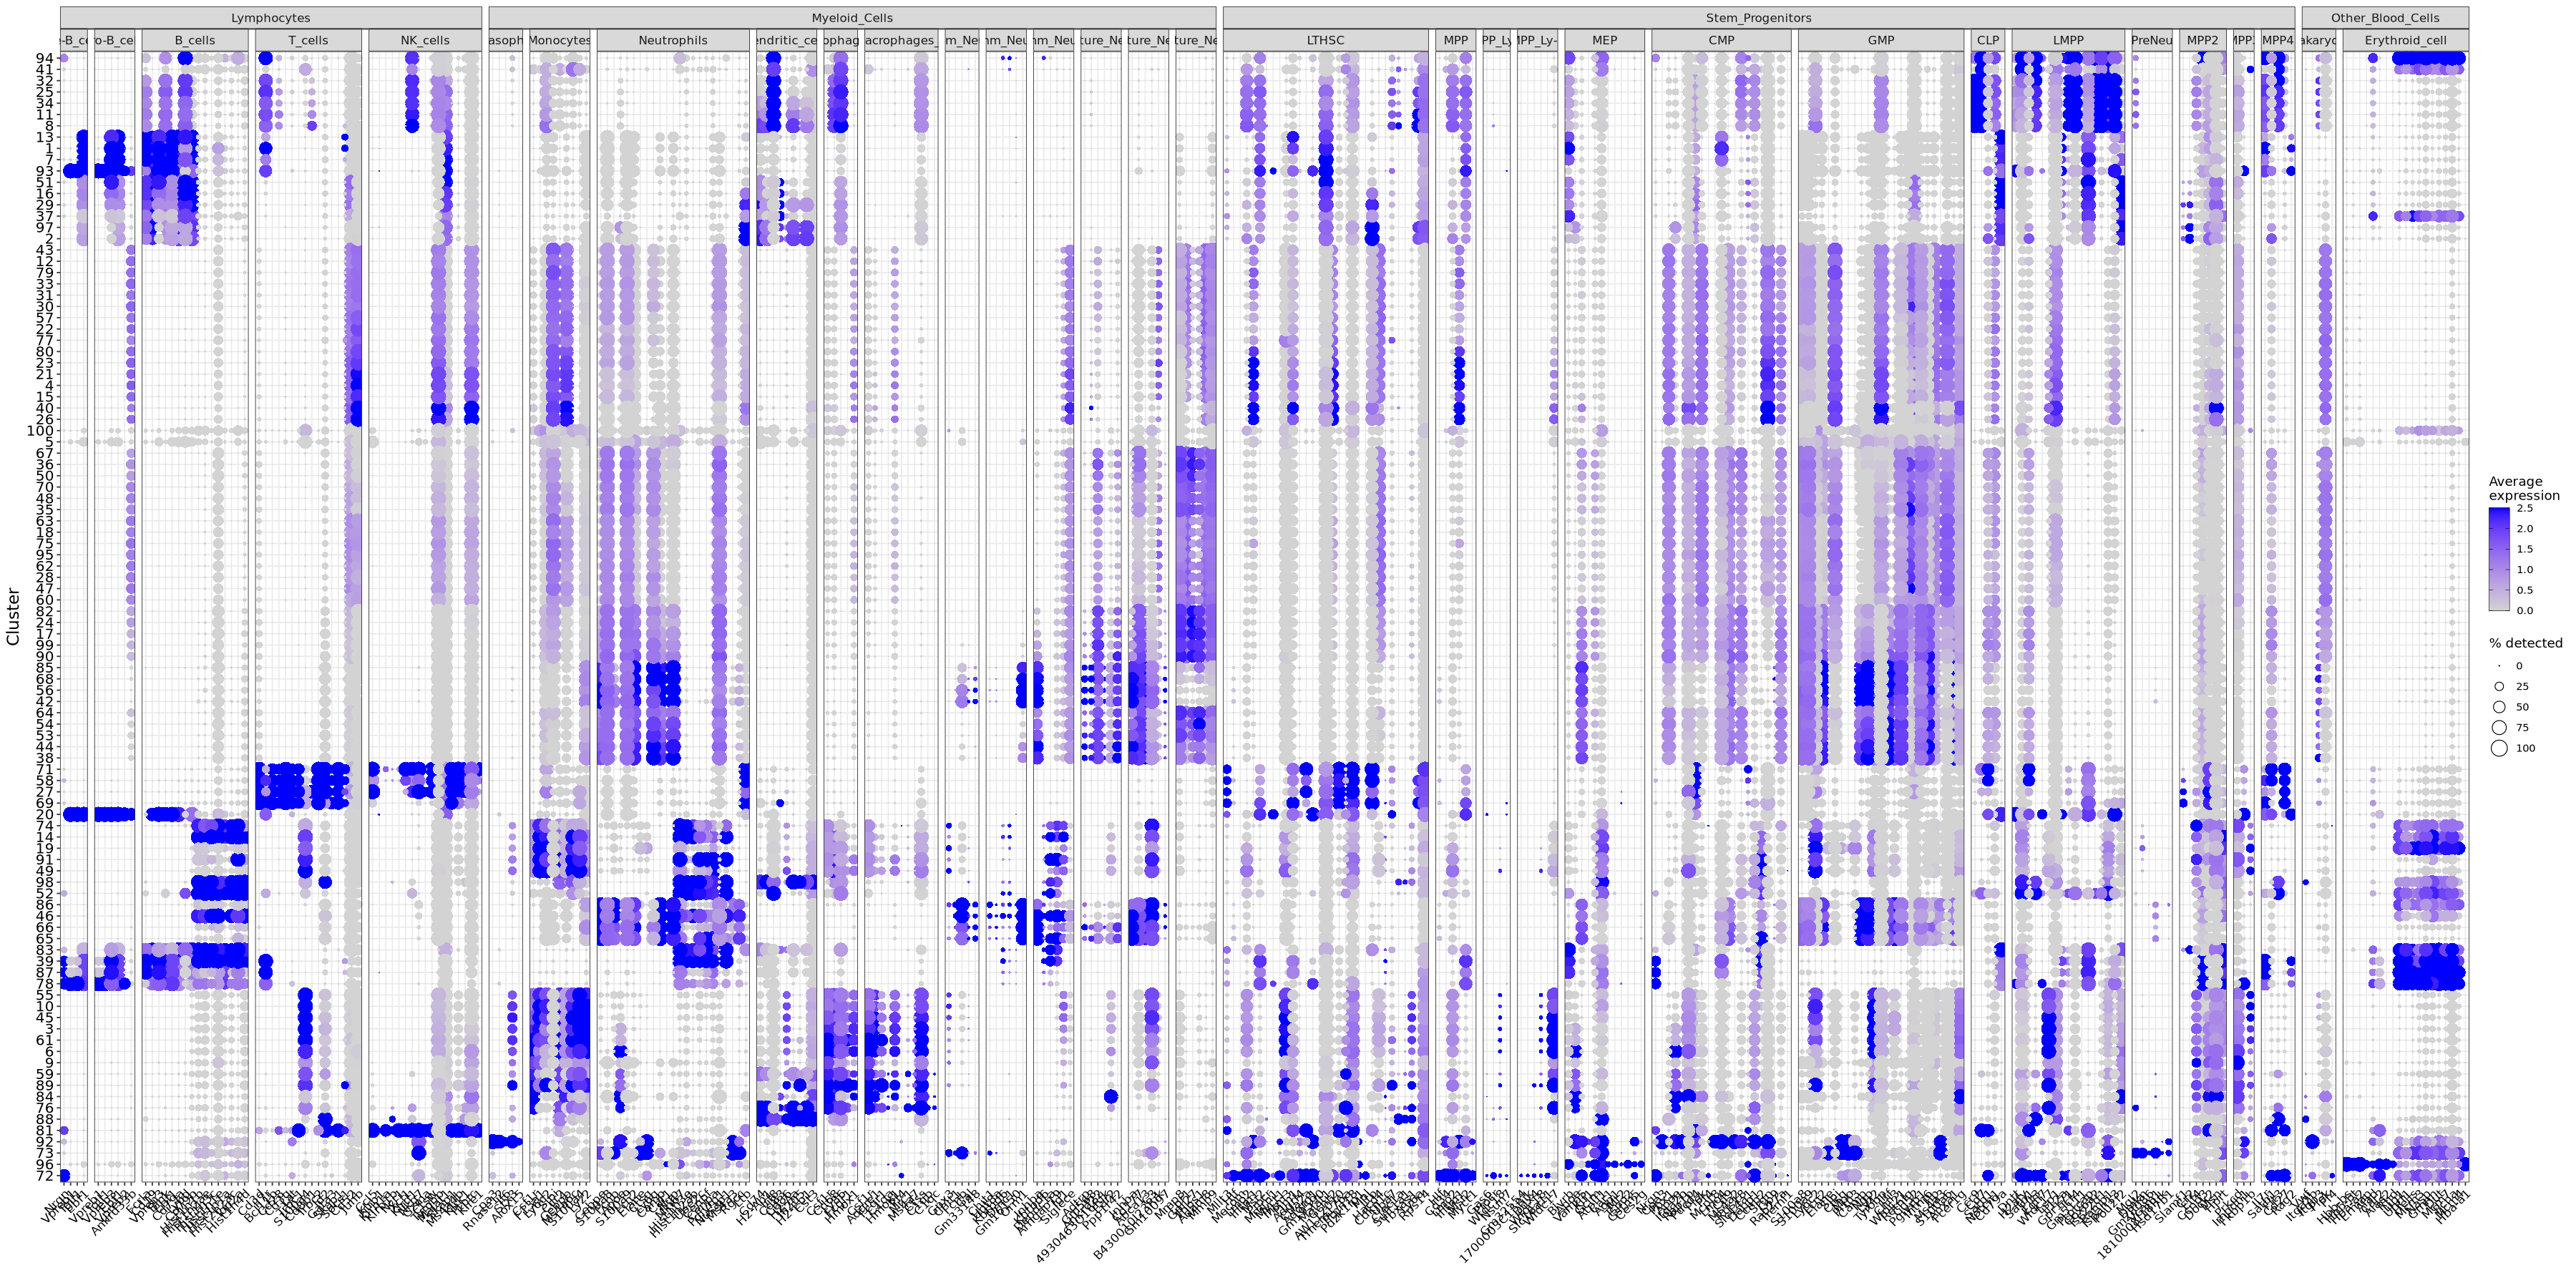

In [36]:
# Filter markers list for only genes present in the dataset
valid_features <- intersect(cell.markers$marker, rownames(adata[["SCT"]]))
g = DotPlot(adata, assay='SCT', features=valid_features, cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=30, repr.plot.height=15)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
    figure

In [37]:
meta_summary.aggreageted <- aggregate(meta_summary$avg.exp,by=list(Compartment=meta_summary$Compartment,
                                                                   CellType=meta_summary$CellType,
                                                                   id = meta_summary$id),FUN=sum)
colnames(meta_summary.aggreageted)[ncol(meta_summary.aggreageted)] = "aggregated.expr"
max(meta_summary.aggreageted$aggregated.expr)

[1] 4451.888

In [38]:
max.use = 5000

In [39]:
gg3 = ggplot(meta_summary.aggreageted, aes(x = aggregated.expr, y = id)) +
theme_bw() +
  geom_col() +
      xlim(0,max.use)+
      theme(axis.text = element_text(size = 10),
            axis.text.x = element_text(size = 10, angle = 90, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      ylab("Cluster_ID \n") + xlab("\n Agr.exp") +
facet_nested(cols = vars(CellType),
             scales = "free", space = "free_y")

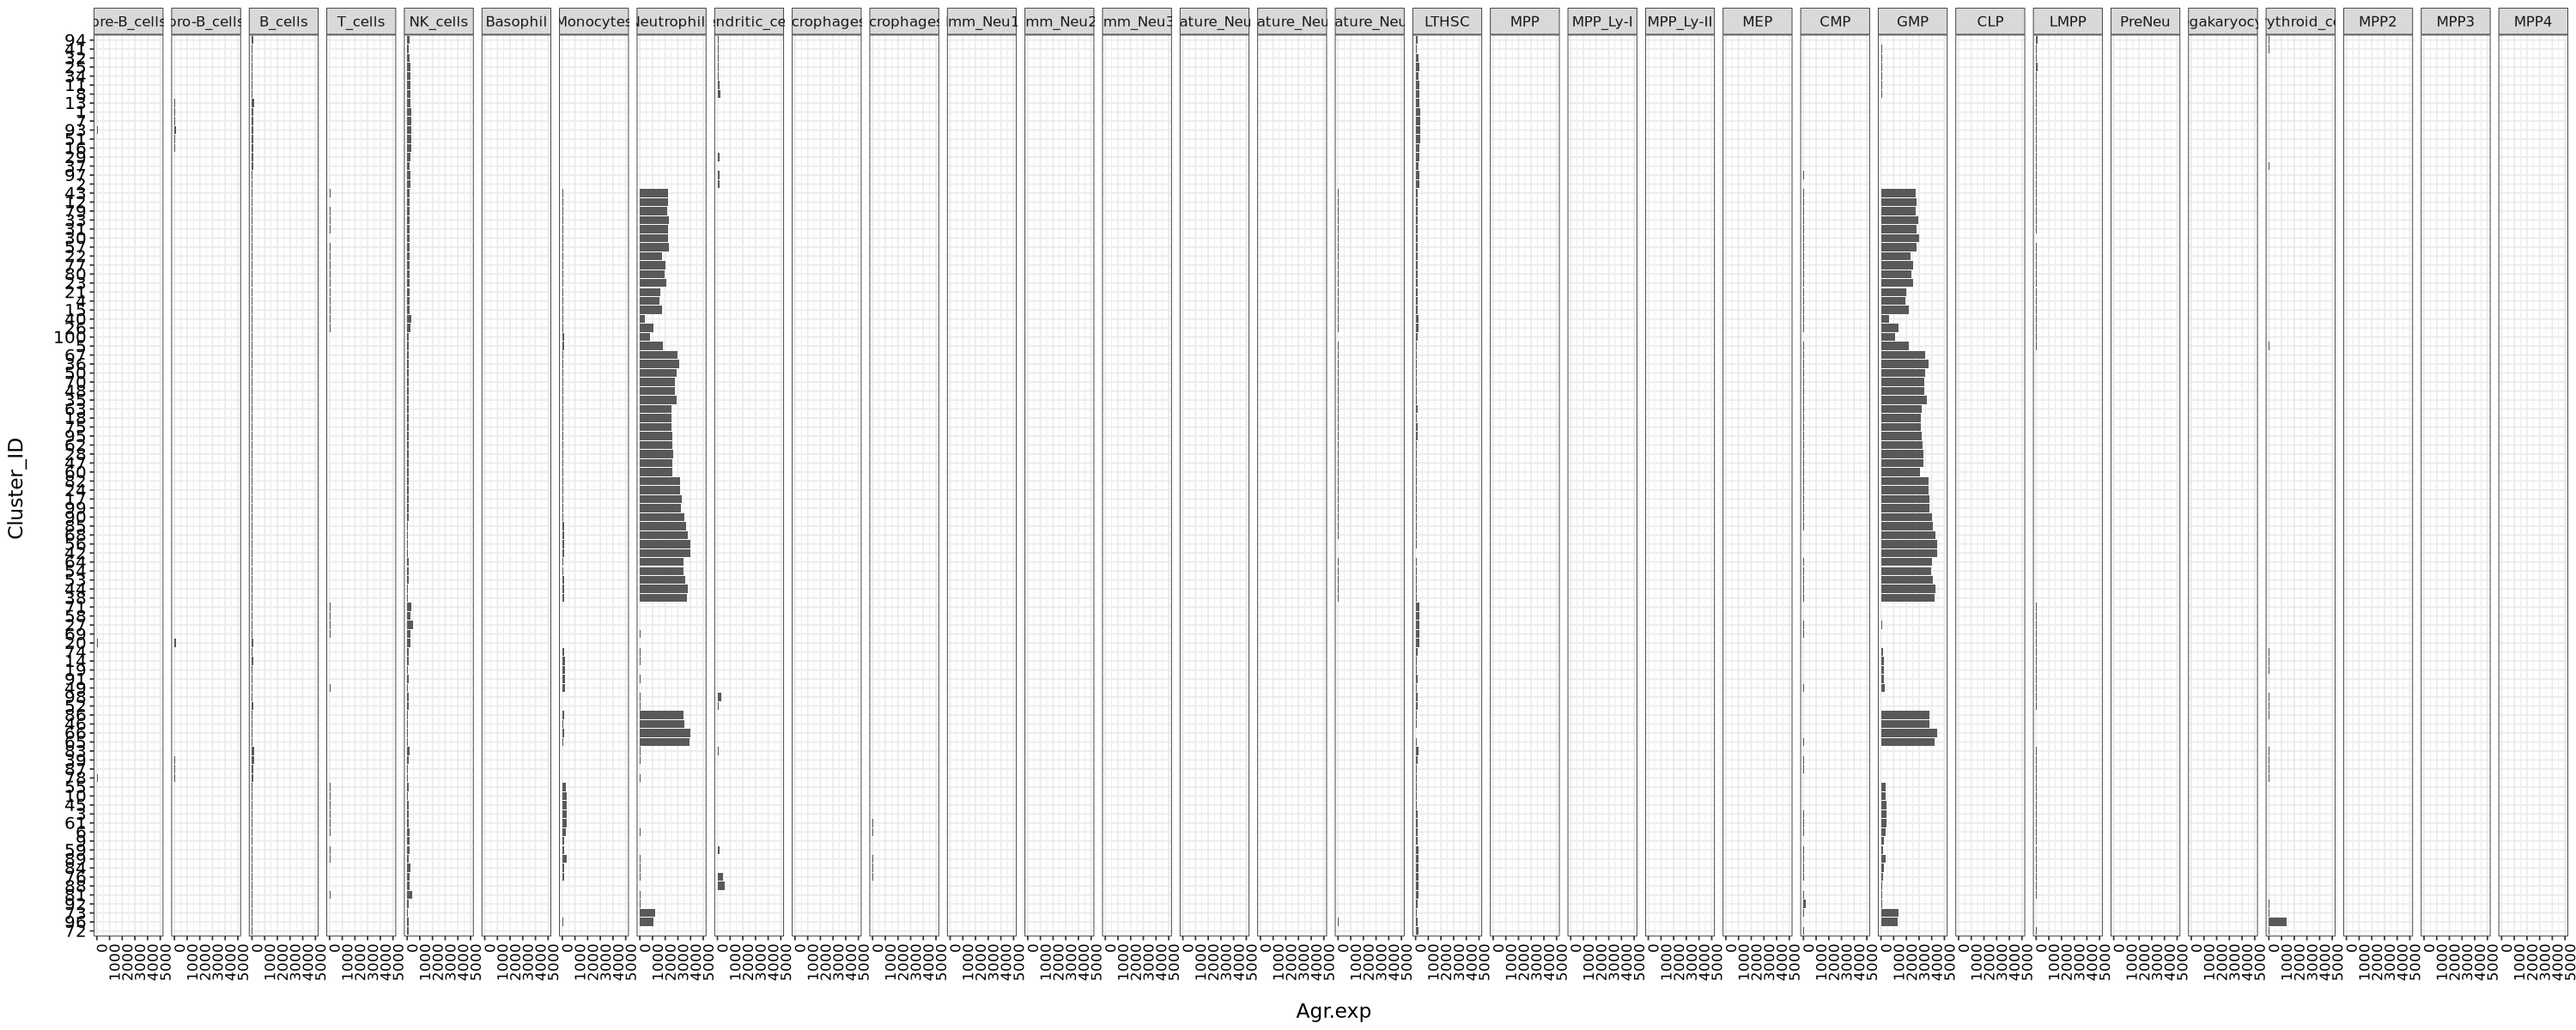

In [40]:
options(repr.plot.width=25, repr.plot.height=10)
gg3

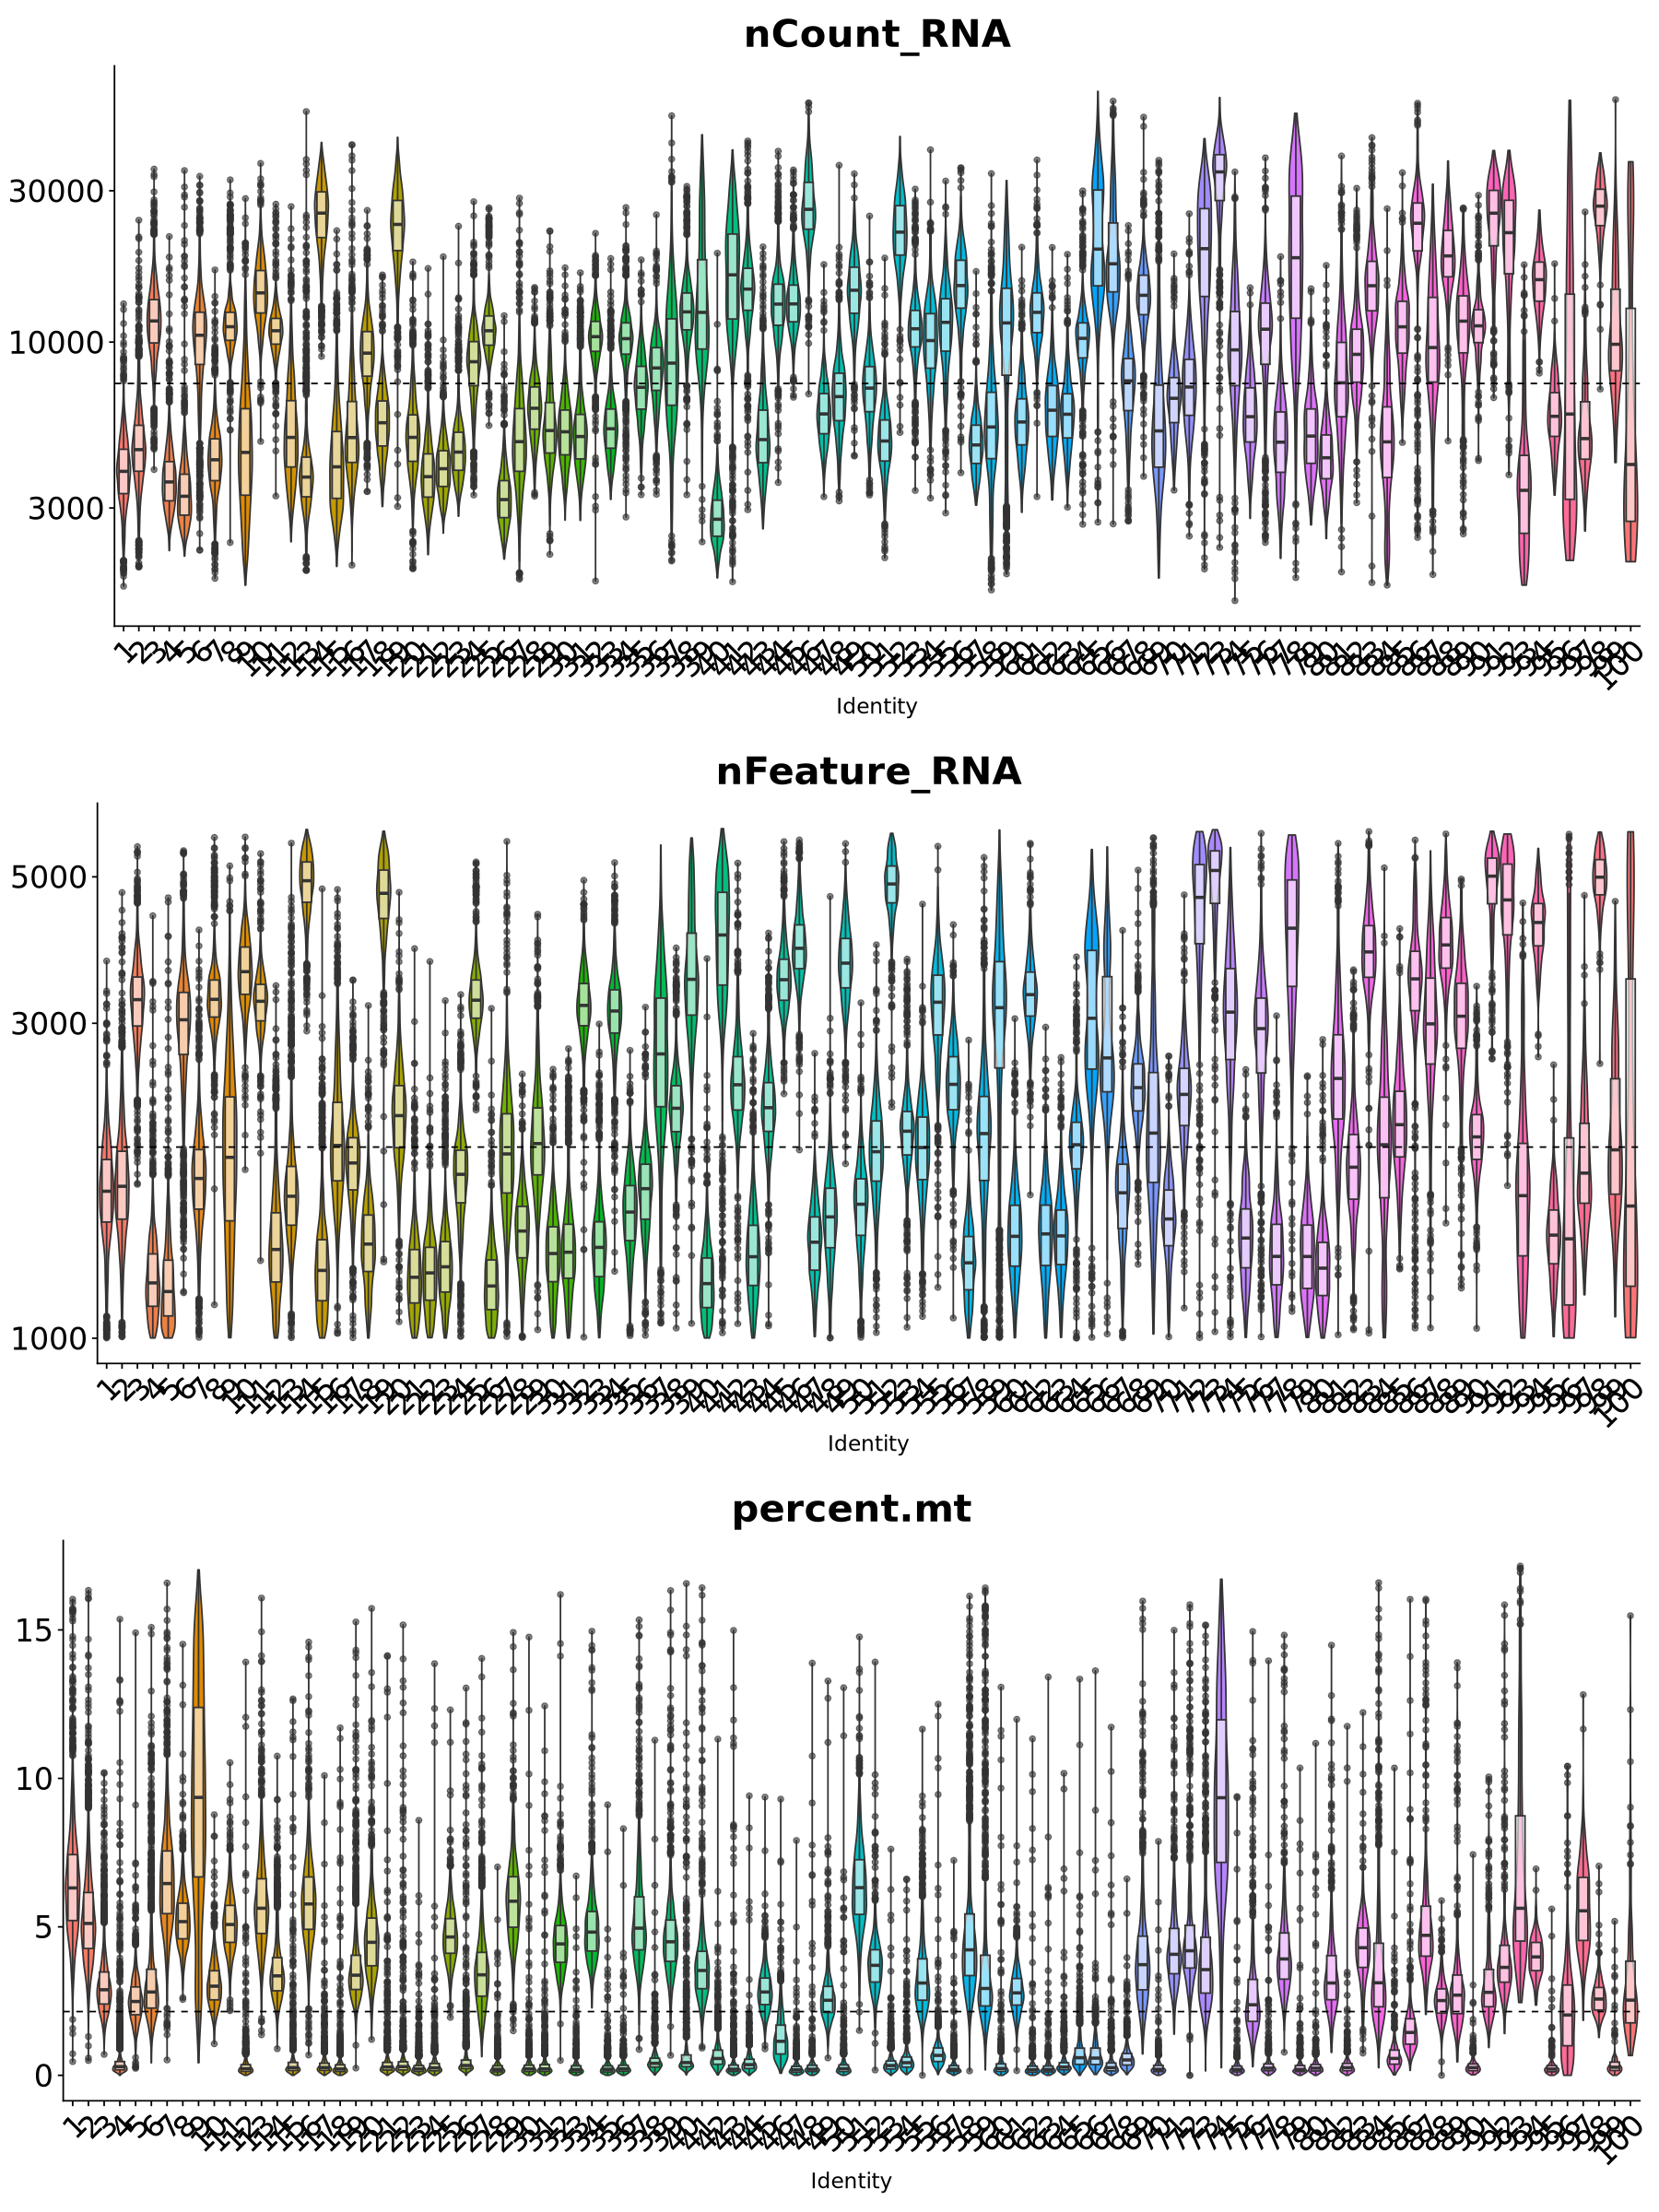

In [41]:
options(repr.plot.height = 20, repr.plot.width = 15)
    p1 <- VlnPlot(adata, features='nCount_RNA', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_RNA), linetype='dashed', lw=2) + 
      theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
    p2 <- VlnPlot(adata, features='nFeature_RNA', group.by='seurat_clusters', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_RNA), linetype='dashed', lw=2) + 
      theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
    p3 <- VlnPlot(adata, features='percent.mt', group.by='seurat_clusters', pt.size=0) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata$percent.mt), linetype='dashed')+
    theme(plot.title = element_text(size = 25), axis.text = element_text(size=20))
    figure <- ggarrange(p1, p2, p3, ncol = 1, nrow = 3,
                        common.legend = TRUE,legend="none")
    figure

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



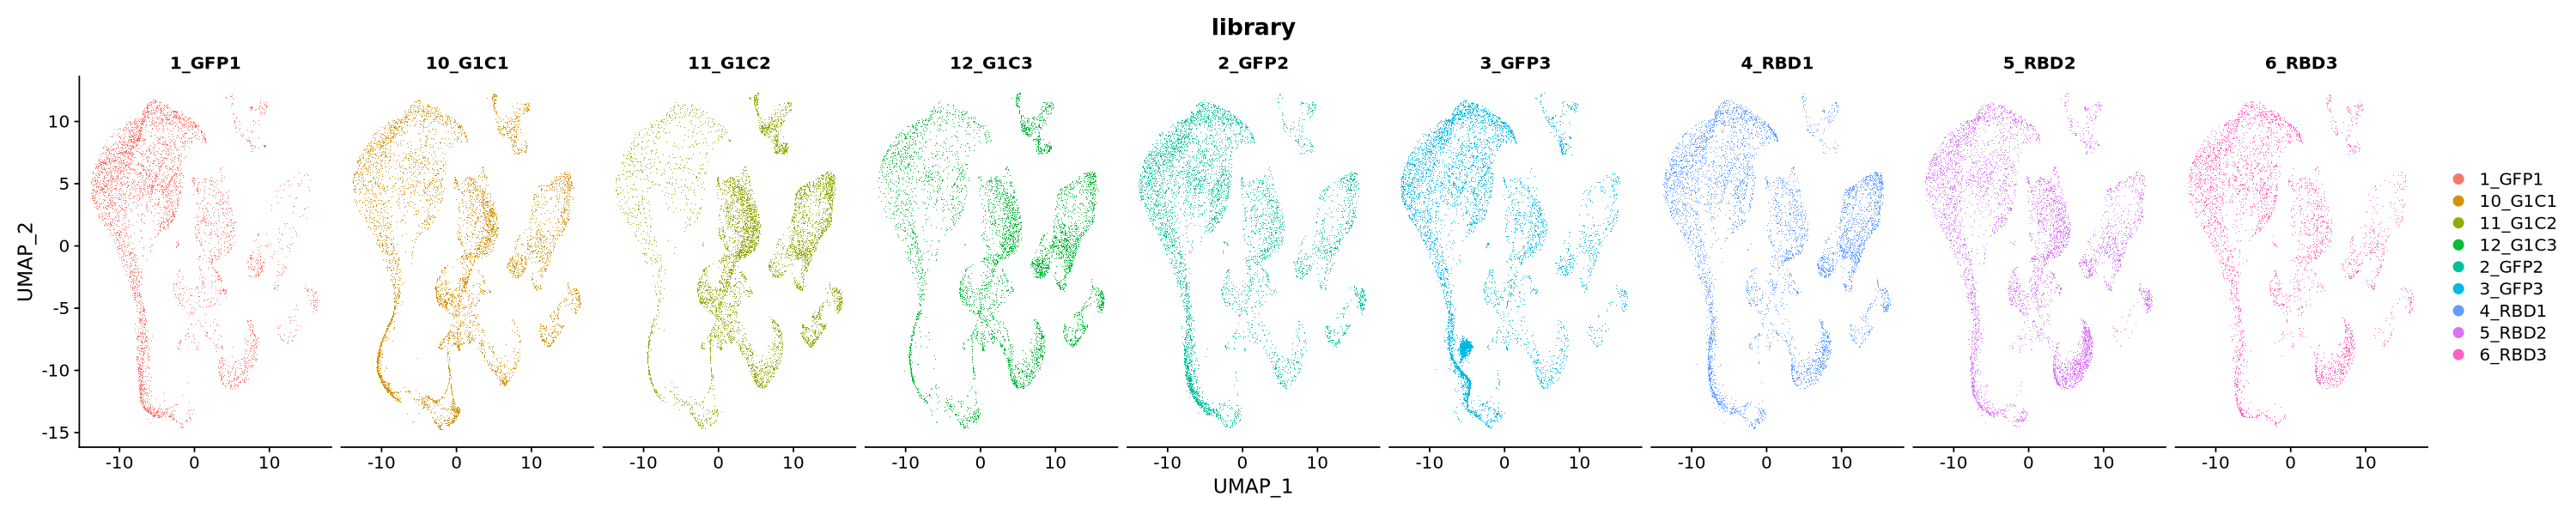

In [42]:
p1 <- DimPlot(adata, reduction='umap', group.by='library', split.by='library', label=FALSE, label.size=6, repel=TRUE)
adata$value <- 1
options(repr.plot.width=25, repr.plot.height=5)
p1

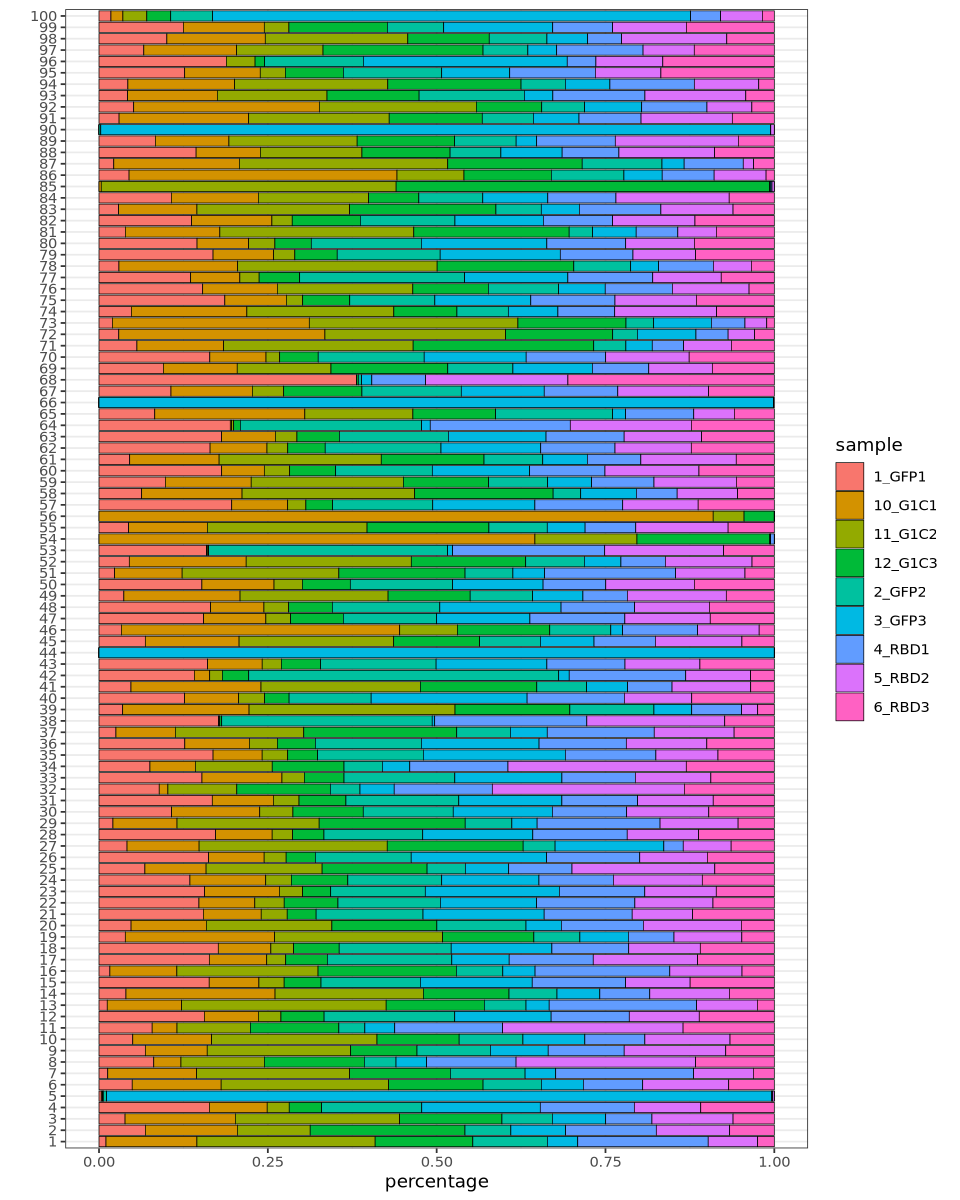

In [43]:
options(repr.plot.width=8, repr.plot.height=10)
sample.abundance = as.data.frame(table(adata$seurat_clusters, adata$library))
colnames(sample.abundance) = c("cluster", "sample", "Freq")
ggplot(sample.abundance, aes(fill = sample, y = Freq, x = cluster)) +
  theme_bw() +
  coord_flip() +
  geom_bar(position = position_fill(reverse = TRUE), stat = 'identity', color = 'black', size = 0.2) +
  xlab('') + ylab('percentage')

In [44]:
### Overwrite  RDS
    file = paste(step4.dir, "snRNAseq_mrg.clean.rds", sep = "")
    saveRDS(adata, file = file)